In [1]:
from flwr_datasets.partitioner import IidPartitioner

partitioner = IidPartitioner(num_partitions=10)

In [2]:
from flwr_datasets import FederatedDataset

hugging_face_dataset_name = 'mnist'
fds = FederatedDataset(dataset=hugging_face_dataset_name,  partitioners={'train': partitioner})

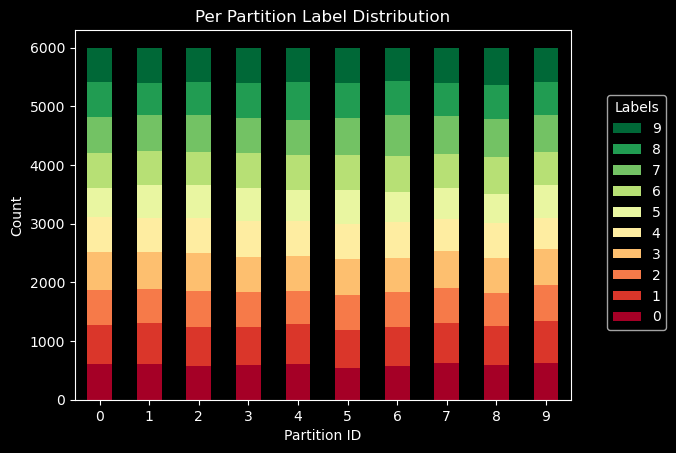

In [3]:
from flwr_datasets.visualization import plot_label_distributions

_ = plot_label_distributions(
    partitioner=fds.partitioners["train"],
    label_name="label",
    legend=True,
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam


def load_model(learning_rate: float = 0.001, verbose = False):
    model = Sequential(
        [
            Input(shape=(28, 28, 1)),
            Conv2D(32, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dropout(0.5),
            Dense(10, activation="softmax"),
        ]
    )
    optimizer = Adam(learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    if verbose:
        model.summary()
        
    return model


In [5]:
from flwr.client import NumPyClient

class FlowerClient(NumPyClient):
    def __init__(self, client_id, model, data):
        self.client_id = client_id
        self.model = model
        self.x_train, self.y_train, self.x_test, self.y_test = data

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history =  self.model.fit(
            self.x_train,
            self.y_train,
            epochs=config['num_local-epochs'],
            batch_size=config['batch-size'],
            verbose=config.get('verbose'),
        )
        res = {key: values[-1] for key, values in history.history.items()}
        res["client-id"] = self.client_id
        res["current-round"] = config["current-round"]
        
        return self.model.get_weights(), len(self.x_train), res

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(
            self.x_test,
            self.y_test, 
            verbose=config.get('verbose'),
        )
        return loss, len(self.x_test), {
            "client-id": self.client_id,
            "current-round": config["current-round"],
            "loss": loss,
            "accuracy": accuracy
        }


In [6]:
from flwr.common import Context
from flwr.client import Client

config = {
    'num_clients' : 10,
    'num_communication-rounds': 3,
    'num_local-epochs' : 1,
    'learning-rate' : 0.005,
    'batch-size': 32,
    'client-sample_fit': 1,
    'client-sample_evaluate': 1,
    'test-size' : 0.2,
    'verbose': False
}

def client_fn(context: Context) -> Client:
    learning_rate = config["learning-rate"]
    verbose = config.get("verbose")

    cnn = load_model(learning_rate, verbose)

    partition_id = context.node_config["partition-id"]
    partition = fds.load_partition(int(partition_id))
    
    partition.set_format("numpy")

    partition = partition.train_test_split(test_size=config['test-size'])
    train_data, test_data = partition['train'], partition['test']

    train_images = train_data['image'] / 255.0
    train_labels = train_data['label']
    test_images = test_data['image'] / 255.0
    test_labels = test_data['label']
    
    data = (train_images, train_labels, test_images, test_labels)
        
    return FlowerClient(partition_id, cnn, data).to_client()


In [7]:
from typing import Dict

def config_fn(server_round: int) -> Dict[str, int]:
    config['current-round'] = server_round
    return config

In [16]:
from typing import List, Tuple, Dict
import numbers

def metrics_aggregation_fn(
    results: List[Tuple[int, Dict[str, float]]]
) -> Dict[str, float]:
    metrics_sum = {}
    total_examples = 0

    for num_examples, metrics in results:
        total_examples += num_examples
        for metric, value in metrics.items():
            if not isinstance(value, numbers.Number):
                continue
            if metric not in metrics_sum:
                metrics_sum[metric] = 0.0
            metrics_sum[metric] += value * num_examples

    averaged_metrics = {metric: value / total_examples for metric, value in metrics_sum.items()}

    return averaged_metrics

In [ ]:
from flwr.server.strategy import FedAvg
from flwr.common import ndarrays_to_parameters

server_config = config_fn(-1)

initial_model = load_model(learning_rate=server_config['learning-rate'])

strategy = FedAvg(
    fraction_fit=server_config["client-sample_fit"],
    fraction_evaluate=server_config["client-sample_evaluate"],
    on_fit_config_fn=config_fn,
    on_evaluate_config_fn=config_fn,
    fit_metrics_aggregation_fn=metrics_aggregation_fn,
    evaluate_metrics_aggregation_fn=metrics_aggregation_fn,
    initial_parameters=ndarrays_to_parameters(initial_model.get_weights()),
)

In [18]:
from flwr.simulation import start_simulation
from flwr.server import ServerConfig

history = start_simulation(
    client_fn=client_fn,
    num_clients=server_config['num_clients'],
    config=ServerConfig(num_rounds=server_config['num_communication-rounds']),
    strategy=strategy
)



INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-12-03 23:07:02,949	INFO worker.py:1816 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 7926459597.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 

In [34]:
history.metrics_distributed['loss']

[(1, 0.3192979544401169), (2, 0.0898123100399971), (3, 0.07099378816783428)]

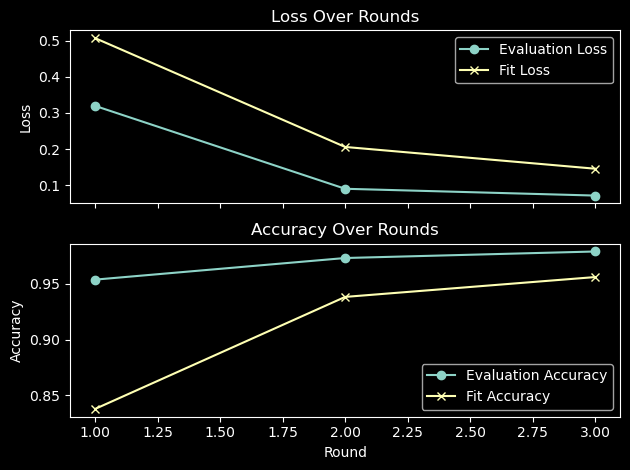

In [39]:
import matplotlib.pyplot as plt

rounds = range(1, config['num_communication-rounds']+1)

fig, (ax1, ax2 )= plt.subplots(2, 1, sharex=True)
ax1.plot(rounds, dict(history.metrics_distributed['loss']).values(), label='Evaluation Loss', marker='o')
ax1.plot(rounds, dict(history.metrics_distributed_fit['loss']).values(), label='Fit Loss', marker='x')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Over Rounds')

ax2.plot(rounds, dict(history.metrics_distributed['accuracy']).values(), label='Evaluation Accuracy', marker='o')
ax2.plot(rounds, dict(history.metrics_distributed_fit['accuracy']).values(), label='Fit Accuracy', marker='x')
ax2.set_xlabel('Round')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Accuracy Over Rounds')

plt.tight_layout()
plt.show()